Create the environment.

In [1]:
import gym
import gym_continuous_maze

env = gym.make("ContinuousMaze-v0")


Choose the device.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [3]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer


buffer = ReplayBuffer(10000, env.observation_space, env.action_space, device=device)

for episode in range(100):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

Build the model.

In [4]:
from go_explore.vae import Linear_VQ_VAE

vae = Linear_VQ_VAE(2).to(device)


/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


## Test the VAE

Sample a batch of observations.

In [5]:
input = buffer.sample(10).observations

Build the reconstruction.

In [6]:
recons, vq_loss, perplexity = vae(input)

Visualize the result.

In [7]:
input, recons

(tensor([[-3.8503, -1.3152],
         [ 1.0859, -0.8845],
         [-0.6544, -0.6672],
         [ 0.2322, -1.7428],
         [ 0.8650, -0.5934],
         [-2.2742, -1.3819],
         [ 0.3259, -0.5615],
         [-4.8408, -0.0652],
         [ 0.9365, -1.5655],
         [-0.6709, -0.9407]], device='cuda:0'),
 tensor([[ 0.2449, -0.2554],
         [ 0.1766, -0.2440],
         [ 0.2554, -0.2591],
         [ 0.1950, -0.2427],
         [ 0.1993, -0.2551],
         [ 0.2274, -0.2502],
         [ 0.2192, -0.2502],
         [ 0.2443, -0.2544],
         [ 0.2135, -0.2485],
         [ 0.2596, -0.2605]], device='cuda:0', grad_fn=<AddmmBackward0>))

## Train the model

Create a loss function.

In [8]:
import torch.nn.functional as F
from typing import Tuple
from torch import Tensor


def loss_func(inputs: Tensor, recons: Tensor, vq_loss: Tensor) -> Tuple[Tensor, Tensor]:
    # Reconstruction loss
    recons_loss = F.mse_loss(inputs, recons)  # / data_variance

    # Total loss
    loss = recons_loss + 0.001*vq_loss

    return loss, recons_loss


Test the loss function.

In [9]:
loss_func(input, recons, vq_loss)

(tensor(0.3341, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(3.0031, device='cuda:0', grad_fn=<MseLossBackward0>))

Create optimizer.

In [10]:
from torch import optim

optimizer = optim.Adam(vae.parameters(), lr=2e-4)


In [19]:
perplexities = []
for epoch in range(5000):
    # Sample
    input = buffer.sample(128).observations

    # Compute the output image
    vae.train()
    recons, vq_loss, perplexity = vae(input)

    # Compute the loss
    loss, recons_loss = loss_func(input, recons, vq_loss)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    perplexities.append(perplexity.item())

    if epoch % 1000 == 0:
        print(
            "epoch: {:5d}\tloss: {:.5f}\trecons loss: {:.5f}\tvq loss: {:.5f}".format(
                epoch, loss.item(), recons_loss.item(), vq_loss.item()
            ),
        )
        vae.eval()


epoch:     0	loss: 3.33540	recons loss: 3.10775	vq loss: 30.24626
epoch:  1000	loss: 4.63747	recons loss: 3.29905	vq loss: 43.07561
epoch:  2000	loss: 10.67723	recons loss: 3.73394	vq loss: 103.03839
epoch:  3000	loss: 13.35366	recons loss: 2.93960	vq loss: 130.59703
epoch:  4000	loss: 11.56334	recons loss: 3.57376	vq loss: 112.05963


In [20]:
input = buffer.sample(10).observations
recons, vq_loss, perplexity = vae(input)
F.mse_loss(input, recons)

tensor(7.2298, device='cuda:0', grad_fn=<MseLossBackward0>)

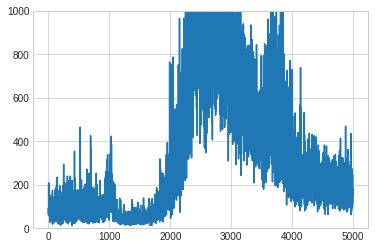

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.set_ylim(0, 1000)

ax.plot(perplexities);

In [22]:
from go_explore.cells import get_param_score

input = buffer.sample(512).observations

# Compute the output image
vae.eval()
quantized = vae.get_quantized(input).flatten(1)
get_param_score(quantized)


0.5102976274660542

In [23]:
input = buffer.sample(10).observations
input, vae(input)[0]

(tensor([[-2.8215, -0.6579],
         [-4.2676,  1.7508],
         [-4.7305,  0.9056],
         [ 1.9043, -1.0886],
         [-0.7551, -1.8200],
         [ 1.5072, -0.7871],
         [ 0.8103, -0.1571],
         [ 0.5682, -1.7440],
         [ 1.0885,  0.2978],
         [-2.1058,  0.4611]], device='cuda:0'),
 tensor([[-0.6614,  0.4910],
         [-0.6614,  0.4910],
         [-0.6614,  0.4910],
         [-0.6614,  0.4910],
         [ 0.4048, -0.0057],
         [-0.6614,  0.4910],
         [-0.6614,  0.4910],
         [-0.6614,  0.4910],
         [-0.6614,  0.4910],
         [-0.6614,  0.4910]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [24]:
vae.encode(input)

tensor([[[ 5.7247e+00],
         [ 1.5395e+00],
         [ 6.8594e+00],
         [ 6.6407e+00],
         [ 1.8874e+01],
         [ 2.2118e+00]],

        [[ 9.4913e+00],
         [ 3.3866e+00],
         [ 1.1616e+01],
         [ 1.1582e+01],
         [ 3.9805e+01],
         [ 3.4912e+00]],

        [[ 1.0267e+01],
         [ 3.4147e+00],
         [ 1.2568e+01],
         [ 1.2344e+01],
         [ 4.0913e+01],
         [ 3.6717e+00]],

        [[-4.8380e+00],
         [-1.1037e+00],
         [-7.1200e+00],
         [-7.2170e+00],
         [-3.0377e+01],
         [-2.3957e+00]],

        [[ 2.1310e-01],
         [ 1.0399e-02],
         [-1.6251e-01],
         [-4.0244e-01],
         [-9.1735e+00],
         [-1.6094e-01]],

        [[-4.0655e+00],
         [-9.7030e-01],
         [-6.0349e+00],
         [-6.1393e+00],
         [-2.5351e+01],
         [-1.9318e+00]],

        [[-2.6674e+00],
         [-7.4576e-01],
         [-4.0693e+00],
         [-4.1990e+00],
         [-1.6018e+01],
    